Import Statments and Parameters:

--------------------------------------------------------------------

IMPORTANT: Run these pip installs,

If using miniconda: ```conda create --name project_env python=3.11```

```pip install tensorflow keras numpy pandas requests Pillow scikit-learn matplotlib opencv-python jupyter ipykernel```

Download dataset here: https://iris.di.ubi.pt/ubipr.html (Original version, Change DATASET_PATH accordingly)

--------------------------------------------------------------------

`IMG_SIZE` - All Images scaled to this size.

`BATCH_SIZE` - Groups pairs of images for siamese training.

In [18]:
print("Importing...")
from lib import *
print("Imported required modules.")

# -----------------------------
# PARAMETERS
# -----------------------------
IMG_SIZE = (105, 105)
IMG_WITH_CHANNELS_SIZE = (105, 105, 3)
BATCH_SIZE = 32
EPOCHS = 4  # increase for better results
STEPS_PER_EPOCH = 50
# -----------------------------

env = EnvLoader("paths.env")
print(str(env))

Importing...
Imported required modules.
EnvLoader[
          RAW_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\UBIPeriocular
         MODEL_SAVE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\siamese_eye_model.keras
      GALLERY_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\Gallery
  GALLERY_EMBEDDING_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\gallery_embeddings.npy
        QUERY_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\query_image.jpg
         TEST_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\TestImages
    PROCESSED_IMAGE_PATH=C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\images_dict.npy
]


Image Preparation: Generates tensorflow dataset for training and saves it to a cache.  (Only use if new data has been added to training data, otherwise go to next cell)

In [ ]:
# -----------------------------
# IMAGE PREPARATION
# -----------------------------

# Check if processed images already exist
if os.path.exists(env.PROCESSED_IMAGE_PATH):
    # Load already processed images (took 12s)
    print("Loading preprocessed images from cache...")
    images_dict = np.load(env.PROCESSED_IMAGE_PATH, allow_pickle=True).item()
else:
    # Process images for the first time (took 10m 57s)
    print("Processing raw images...")
    images_dict = load_images_by_filename(env.RAW_IMAGE_PATH, IMG_SIZE)
    
    print(f"Saving preprocessed images to {env.PROCESSED_IMAGE_PATH}...")
    np.save(env.PROCESSED_IMAGE_PATH, images_dict)

train_ds = make_tf_dataset(images_dict, BATCH_SIZE, IMG_SIZE)


# sanity check
def get_image_counts():
    images_per_person = [len(imgs) for _person, imgs in images_dict.items()]
    bins = np.bincount(images_per_person)
    indices = np.arange(0, bins.shape[0])
    return np.transpose(np.array((indices, bins)))

get_image_counts()

Training:

In [ ]:
# -----------------------------
# TRAINING
# -----------------------------
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

early_stop = EarlyStopping(
    monitor='loss',
    patience=5,            # stop after 5 epochs with no improvement
    restore_best_weights=True
)

model, base_cnn = create_siamese_model(input_shape=IMG_WITH_CHANNELS_SIZE)
model.compile(loss=contrastive_loss,
              optimizer=Adam(learning_rate=1e-4),
              metrics=[siamese_accuracy])
model.summary()

model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

In [ ]:
# Call this after training:
save_siamese_model(model, str(env.MODEL_SAVE_PATH))

In [13]:
crop_gallery_images(env.GALLERY_IMAGE_PATH, IMG_SIZE)

Compare Eyes: Uses identify_eye() to compare query_image with images in gallery and outputs highest similarity image.

------------------------------------------------------------------
IMPORTANT:

Run previous definition cells.

Gallery should contain subfolders for each person containing images of their eyes.

Subfolder name should be persons names/identifier.

------------------------------------------------------------------

Saved embeddings to C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\gallery_embeddings.npy


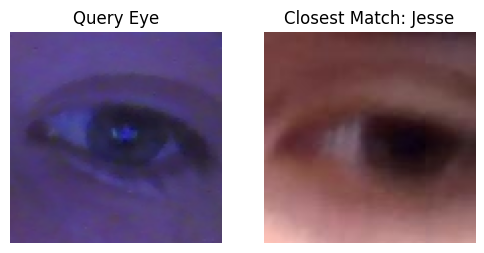

Identified as: Jesse with confidence 80.95%


In [14]:
model = load_siamese_model(env.MODEL_SAVE_PATH)

# Load gallery
gallery_dict = load_gallery_images(env.GALLERY_IMAGE_PATH)

try: 
    _ = base_cnn
except NameError as e:
    base_cnn = create_base_cnn(IMG_WITH_CHANNELS_SIZE)

# Compute embeddings using base_cnn, not model
gallery_embeddings = compute_gallery_embeddings(
    base_cnn,
    gallery_dict,
    IMG_WITH_CHANNELS_SIZE,
    env.GALLERY_EMBEDDING_PATH
)

# Identify query using base_cnn
identity, confidence = identify_eye(
    env.QUERY_IMAGE_PATH,
    base_cnn,
    gallery_embeddings,
    IMG_SIZE,
    margin=1.0,
    threshold=70.0
)

print(f"Identified as: {identity} with confidence {confidence:.2f}%")

Identifies all images in TestImages

Loaded cached embeddings from C:\Users\Gunnar\Files\School_Stuff\IntroToAi\AiFinalProject\gallery_embeddings.npy


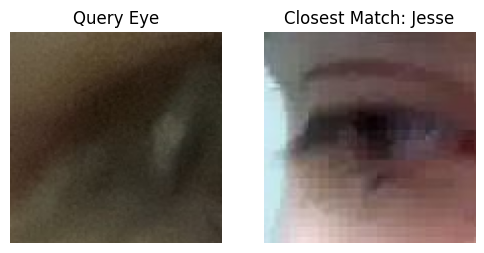

Test01.jpg → Identified as: Jesse with confidence 78.24%


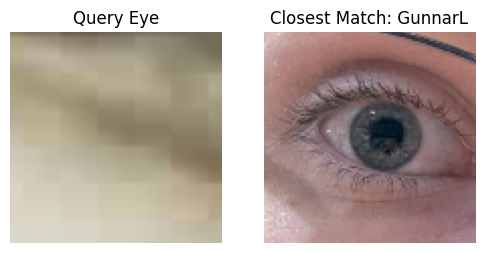

Test02.jpg → Identified as: GunnarL with confidence 80.33%
No eye detected in query image.


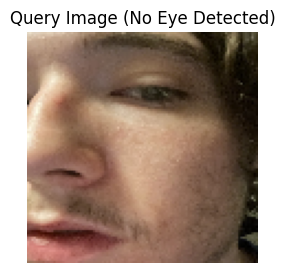

Test03.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.


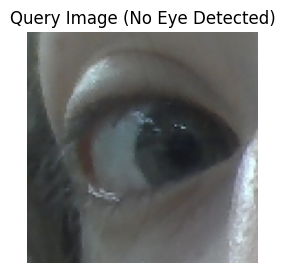

Test04.jpg → Identified as: No eye detected with confidence 0.00%


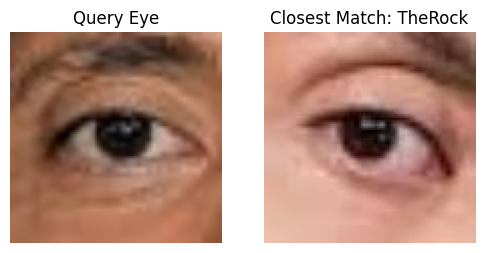

Test05.jpg → Identified as: Unknown with confidence 69.35%
No eye detected in query image.


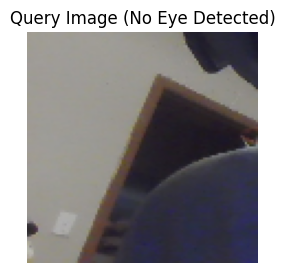

Test06.jpg → Identified as: No eye detected with confidence 0.00%
No eye detected in query image.


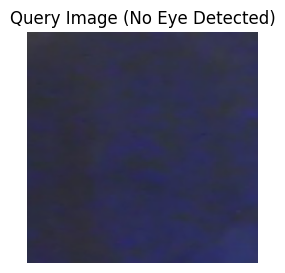

Test07.jpg → Identified as: No eye detected with confidence 0.00%


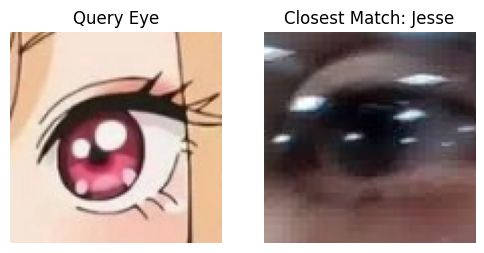

Test08.png → Identified as: Unknown with confidence 30.92%


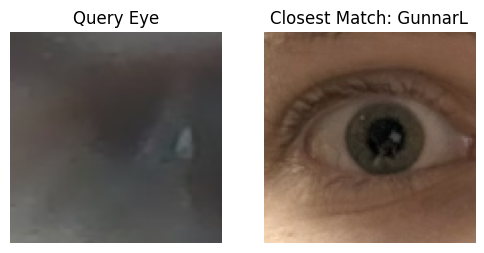

Test09.jpg → Identified as: GunnarL with confidence 83.04%


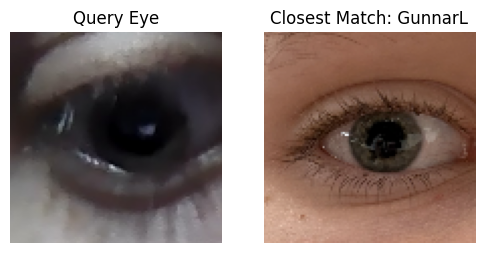

Test10.jpg → Identified as: Unknown with confidence 66.96%


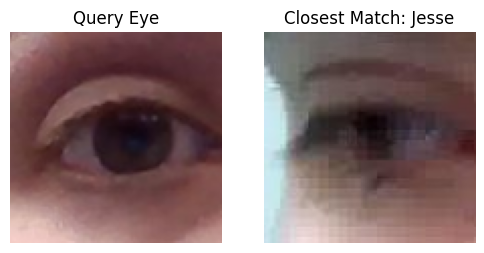

Test11.jpg → Identified as: Jesse with confidence 81.66%


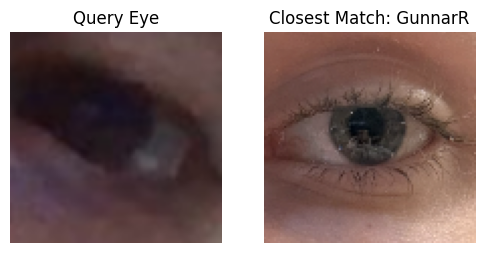

Test12.jpg → Identified as: GunnarR with confidence 76.49%


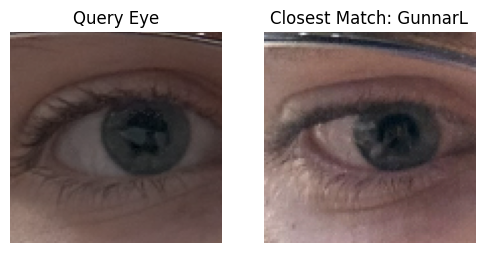

Test13_GunnarL.png → Identified as: GunnarL with confidence 86.18%


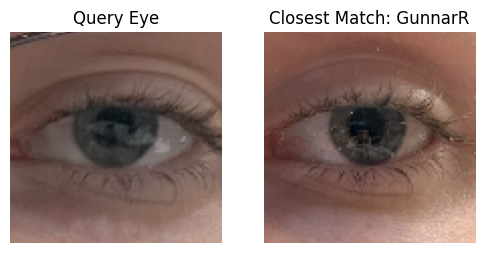

Test14_GunnarR.png → Identified as: GunnarR with confidence 89.12%


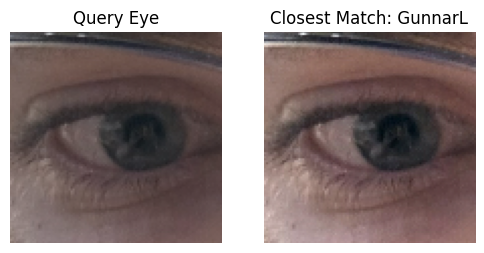

Test15_Gunnar_glasses2L.png → Identified as: GunnarL with confidence 91.87%


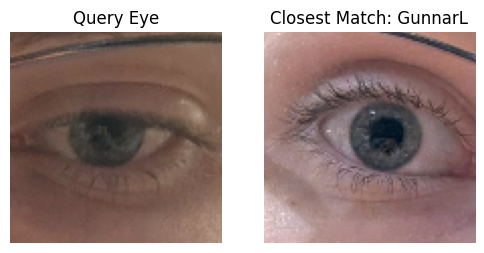

Test16_Gunnar_glasses2R.png → Identified as: GunnarL with confidence 82.21%


In [17]:
# -----------------------------
# Load Siamese model
# -----------------------------
model = load_siamese_model(env.MODEL_SAVE_PATH)

# -----------------------------
# Reconstruct base CNN and load weights
# -----------------------------
try: 
    _ = base_cnn
except NameError as e:
    base_cnn = create_base_cnn(IMG_WITH_CHANNELS_SIZE)

# Copy weights from the trained Siamese model
# In the Siamese model, the base CNN is the 3rd layer (index 2)
# Adjust if your layer ordering differs
for base_layer, siam_layer in zip(base_cnn.layers, model.layers[2].layers):
    base_layer.set_weights(siam_layer.get_weights())

# -----------------------------
# Load gallery
# -----------------------------
gallery_dict = load_gallery_images(env.GALLERY_IMAGE_PATH)

# -----------------------------
# Compute gallery embeddings (or load cached)
# -----------------------------
gallery_embeddings = compute_gallery_embeddings(
    base_cnn,
    gallery_dict,
    img_size=IMG_SIZE,
    embedding_cache_path=env.GALLERY_EMBEDDING_PATH
)

# -----------------------------
# Identify test images
# -----------------------------
for img_name in os.listdir(env.TEST_IMAGE_PATH):
    if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue
    
    query_image = os.path.join(env.TEST_IMAGE_PATH, img_name)

    identity, confidence = identify_eye(
        query_image,
        base_cnn,
        gallery_embeddings,
        img_size=IMG_SIZE,
        margin=1.0,
        threshold=70.0
    )

    print(f"{img_name} → Identified as: {identity} with confidence {confidence:.2f}%")
